2018 Edition

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

# 1. Introduction

In [5]:
%matplotlib inline
from random import *
from scipy import stats
from math import *
from datetime import datetime
from datetime import timedelta
from itertools import islice
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns



/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


In [6]:
average_unit = (50000+75000+100000)/3
average_price = (11+8+10)/3
print("average unit:", average_unit)
print("average price", average_price)

average unit: 75000.0
average price 9.666666666666666


## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

In [7]:
def calNetProfit(average_unit, average_price, average_unitcost, fixed_cost):
    return average_unit * (average_price - average_unitcost) - fixed_cost

average_unitcost = 6.5
fixed_cost = 120000
netProfit = calNetProfit(average_unit, average_price, average_unitcost, fixed_cost)
print("Net profit:", netProfit)


Net profit: 117499.99999999994


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<ul></ul>

$$ error = \frac{your\_value - true\_value}{true\_value}$$

<ul></ul>
Note also we are interested in displaying the error as a percentage.
<ul></ul>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

In [8]:
trueNetProfit = 93000
error = (netProfit - trueNetProfit) / (trueNetProfit)
print("Error: {}%".format(round(error * 100, 2)))


Error: 26.34%


<div class="alert alert-success">
With an error of <strong>more than 25%</strong>, we cannot hope to have good economical results using such a model. The value is fairly high, and we know that taking an average from all of our variables loses the possible relationships between different variables. For example, we lose some of the information about the relationship between the volume and the price.
</div>

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

In [9]:

# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (50000,11)
    # Normal market
    if scenario == 1:
        return (75000,10)
    # Hot market
    if scenario == 2:
        return (100000,8)


#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.  
<ul></ul>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.  
</div>


<div class="label label-success">HINT</div>  

Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$

In [10]:

import random

total = 0.0
num_simulations = 100000
Y=[]; E=[]
for i in range(1,num_simulations+1):
    unit_cost = uniform(6.5,9.5)
    market_scenario = randint(0,2)
    sales_volume, price = get_sales_volume_price(market_scenario)
    tmpNetProfit = calNetProfit(sales_volume, price, average_unitcost, fixed_cost)
    total+=tmpNetProfit 
    Y.append(total/i)
    E.append(100*abs(trueNetProfit - (total/i))/trueNetProfit)

avgNetProfit = total/num_simulations
print("Average net profit:", avgNetProfit)
MCError = abs(trueNetProfit - avgNetProfit)/trueNetProfit
print("Error: {}%".format(round(MCError * 100, 3)))


Average net profit: 92509.125
Error: 0.528%


<div class="alert alert-success">
<p>As expected, we get much better results with Monte Carlo, since we get an error of <strong>less than 1%</strong>.</p>
<p>When using the average of all variables like we did with the previous model (<i>average</i> model), we lose information about the relationships between them, and we therefore only have one try at predicting the <i>net profit</i>. With the MCS, we choose specific values for the variables (randomly, using <code>uniform()</code>, which allows for a more realistic result. And we are able to get close to the real <i>net profit</i> by looping over this. We are able to keep the different relationships that can exist between variables (volume-price for example), and using a loop to generate several simulations allow us to get closer to the real value.</p>
<p>As we can see on the graph below, the number of simulations does matter, and we can see a sort of convergence towards our final value $92,434.</p>
</div>

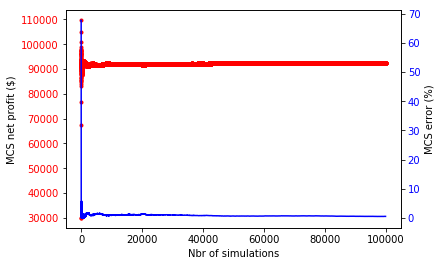

In [11]:
def two_scales(ax1, time, data1, data2):
    """https://matplotlib.org/2.1.2/gallery/api/two_scales.html"""
    ax2 = ax1.twinx()
    ax1.plot(time, data1, 'r.')
    ax1.set_xlabel('Nbr of simulations')
    ax1.set_ylabel('MCS net profit ($)')
    ax2.plot(time, data2, 'b-')
    ax2.set_ylabel('MCS error (%)')
    return ax1, ax2

def color_y_axis(ax, color):
    """https://matplotlib.org/2.1.2/gallery/api/two_scales.html"""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

X = range(num_simulations)
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, X, Y, E)

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.show()


# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- *Normal/Gaussian Distribution*: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe natural phenomena, such as people’s heights, inflation rates, energy prices, and so on and so forth. An illustration of a normal distribution is given below:

![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- *Lognormal Distribution*: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, real estate property values, stock prices, and oil reserves. An illustration of a lognormal distribution is given below:

![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- *Triangular Distribution*: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, past sales history per unit of time and inventory levels. An illustration of a triangular distribution is given below:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- *Uniform Distribution*: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include manufacturing costs or future sales revenues for a new product. An illustration of the uniform distribution is given below:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- *Exponential Distribution*: this is a continuous distribution used to model the time that pass between independent occurrences, provided that the rate of occurrences is known. An example of the exponential distribution is given below:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- *Discrete Distribution* : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!



## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window
  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<ul></ul>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<ul></ul>

Note that we are only interested in the date and price of stocks.

</div>

<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [12]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

In [13]:
base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"

# read data from local disk
def readInvestingDotComHistory(fname):
    def process_line(line):
        cols = line.split('\t')
        date = datetime.strptime(cols[0],"%b %d, %Y")
        value = float(cols[2])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1:]
        content=sorted(list(map(process_line , content)),key=lambda l: l[0])
        return content

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

In [14]:
display(factors1[0][:5])

[(datetime.datetime(2006, 1, 26, 0, 0), 65.85),
 (datetime.datetime(2006, 1, 27, 0, 0), 66.49),
 (datetime.datetime(2006, 1, 30, 0, 0), 67.85),
 (datetime.datetime(2006, 1, 31, 0, 0), 68.4),
 (datetime.datetime(2006, 2, 1, 0, 0), 67.8)]

Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.
</div>

<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

In [15]:
! ls ./monte-carlo-risk/factors/


BTC-USD.csv   GOLD.csv	K.csv	  RUT.csv  us30yeartreasurybonds.tsv
crudeoil.tsv  GSPC.csv	MU.csv	  STM.csv  VIX.csv
DJI.csv       IXIC.csv	N225.csv  TNX.csv


In [16]:
! head -n 3./monte-carlo-risk/factors/GSPC.csv

head: 3./monte-carlo-risk/factors/GSPC.csv: invalid number of lines


In [17]:
! head -n 3 ./monte-carlo-risk/factors/IXIC.csv

Date,Open,High,Low,Close,Volume,Adj Close
2016-01-22,4557.390137,4591.180176,4540.27002,4591.180176,2153340000,4591.180176
2016-01-21,4480.700195,4537.149902,4432.02002,4472.060059,2447750000,4472.060059


In [18]:
! tail -n 1 ./monte-carlo-risk/factors/GSPC.csv
! tail -n 1 ./monte-carlo-risk/factors/IXIC.csv

1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1971-02-05,100.00,100.00,100.00,100.00,000,100.00


In [19]:
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        cols = line.split(',')
        date = datetime.strptime(cols[0],"%Y-%m-%d")
        value = float(cols[1])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1:]
        content=sorted(list(map(process_line , content)),key=lambda l: l[0])
        return content

factor2_files = ['GSPC.csv', 'IXIC.csv']
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [readYahooHistory(f) for f in factor2_files]


In [20]:
display(factors2[0][:5])

[(datetime.datetime(1950, 1, 3, 0, 0), 16.66),
 (datetime.datetime(1950, 1, 4, 0, 0), 16.85),
 (datetime.datetime(1950, 1, 5, 0, 0), 16.93),
 (datetime.datetime(1950, 1, 6, 0, 0), 16.98),
 (datetime.datetime(1950, 1, 9, 0, 0), 17.08)]

<div class="alert alert-success">
    <p>We can see when using <code>tail</code> on both files that the data from GSPC.csv starts in 1950, while the one from IXIC.csv starts in 1971. IF we want to see the impact of both of them on the stocks, we will have to make sure the dates are the same for a given analysis. This is what we will do in the next questions.</p>
</div>

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first 35 stocks out of the total 3000 stocks present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than 5 years of history should be removed.

</div>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

In [21]:
def process_line(line):
    cols = line.split(',')
    date = datetime.strptime(cols[0],"%Y-%m-%d")
    value = float(cols[1])
    return (date, value)

In [22]:
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        return readYahooHistory(fname)
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: ((instrument[-1][0].year-instrument[0][0].year)>=number_of_years)  , rawStocks))

# For testing, print the first 5 entry of the first stock
display(rawStocks[0][:5])

[(datetime.datetime(1997, 8, 14, 0, 0), 39.0),
 (datetime.datetime(1997, 8, 15, 0, 0), 42.0),
 (datetime.datetime(1997, 8, 18, 0, 0), 44.0),
 (datetime.datetime(1997, 8, 19, 0, 0), 55.5),
 (datetime.datetime(1997, 8, 20, 0, 0), 48.0)]

In [23]:
display(rawStocks[0][0], rawStocks[0][-1])

(datetime.datetime(1997, 8, 14, 0, 0), 39.0)

(datetime.datetime(2016, 1, 22, 0, 0), 40.529999)

### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

In [24]:
# note that the data of crude oil and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # only select entries which are in the time region
    trimmed = list(filter(lambda record: isInTimeRegion(record), history))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
print(trimmedStock0[:5])
# the last 5 records of stock 0
print(trimmedStock0[-5:])

assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"

[(datetime.datetime(2009, 1, 23, 0, 0), 19.4), (datetime.datetime(2009, 1, 26, 0, 0), 19.67), (datetime.datetime(2009, 1, 27, 0, 0), 19.809999), (datetime.datetime(2009, 1, 28, 0, 0), 20.469999), (datetime.datetime(2009, 1, 29, 0, 0), 21.41)]
[(datetime.datetime(2014, 1, 16, 0, 0), 37.369999), (datetime.datetime(2014, 1, 17, 0, 0), 37.470001), (datetime.datetime(2014, 1, 21, 0, 0), 37.73), (datetime.datetime(2014, 1, 22, 0, 0), 37.779999), (datetime.datetime(2014, 1, 23, 0, 0), 37.59)]


### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [25]:
def fillInHistory(history, start, end):
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    while curDate < end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] == curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:
            
            filled.append((curDate, curr[idx][1]))
            # move to the next business day
            curDate += timedelta(days=1)
        
        # skip the weekends
        elif curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))

    return filled

#### Question 4.5
<div class="alert alert-info">
Trim data of stocks and factors into the given time interval.
</div>

In [26]:
#print rawStocks[0]

# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))



# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(lambda factor: \
            fillInHistory(
                trimToRegion(factor, start, end), 
            start, end),
        allfactors))
            
# test our code
print("the first 5 records of stock 0:", display(stocks[0][:5]), "\n")
print("the last 5 records of stock 0:", display(stocks[0][-5:]), "\n")
print("the first 5 records of factor 0:", display(factors[0][:5]), "\n")
print("the first 5 records of factor 0:", display(factors[0][-5:]), "\n")

[(datetime.datetime(2009, 1, 23, 0, 0), 19.4),
 (datetime.datetime(2009, 1, 26, 0, 0), 19.67),
 (datetime.datetime(2009, 1, 27, 0, 0), 19.809999),
 (datetime.datetime(2009, 1, 28, 0, 0), 20.469999),
 (datetime.datetime(2009, 1, 29, 0, 0), 21.41)]

the first 5 records of stock 0: None 



[(datetime.datetime(2014, 1, 16, 0, 0), 37.369999),
 (datetime.datetime(2014, 1, 17, 0, 0), 37.470001),
 (datetime.datetime(2014, 1, 20, 0, 0), 37.470001),
 (datetime.datetime(2014, 1, 21, 0, 0), 37.73),
 (datetime.datetime(2014, 1, 22, 0, 0), 37.779999)]

the last 5 records of stock 0: None 



[(datetime.datetime(2009, 1, 23, 0, 0), 43.26),
 (datetime.datetime(2009, 1, 26, 0, 0), 46.05),
 (datetime.datetime(2009, 1, 27, 0, 0), 45.65),
 (datetime.datetime(2009, 1, 28, 0, 0), 41.99),
 (datetime.datetime(2009, 1, 29, 0, 0), 42.22)]

the first 5 records of factor 0: None 



[(datetime.datetime(2014, 1, 16, 0, 0), 94.29),
 (datetime.datetime(2014, 1, 17, 0, 0), 94.17),
 (datetime.datetime(2014, 1, 20, 0, 0), 94.31),
 (datetime.datetime(2014, 1, 21, 0, 0), 94.0),
 (datetime.datetime(2014, 1, 22, 0, 0), 95.2)]

the first 5 records of factor 0: None 



Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [27]:
def buildWindow(seq, k=2):
    '''
    Returns a sliding window (of width k) over data from iterable data structures
       s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ... 
    '''
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

In [28]:
def calculateReturn(window):
    # return the change of value after two weeks
    return window[-1][1] - window[0][1]

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [calculateReturn(entry) for entry in buildWindow(history, 10)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:", stocksReturns[0][:5])
print("the last 5 returns of stock 0:", stocksReturns[0][-5:])

the first 5 returns of stock 0: [0.8000010000000017, 1.0, 0.7200019999999974, -0.27999800000000263, -1.5800000000000018]
the last 5 returns of stock 0: [-1.1599999999999966, -1.4599989999999963, -0.8399999999999963, -0.4599990000000034, 0.0]


Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

In [29]:
import numpy as np

In [30]:
def transpose(matrix):
    m=np.array(matrix)
    return [list(vect) for vect in m.transpose()]

# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"

#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

In [31]:
from math import *
def featurize(factorReturns):
    squaredReturns = [np.sign(x)*x**2 for x in factorReturns]
    squareRootedReturns = [np.sign(x)*sqrt((abs(x))) for x in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns

# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"


For simplicity, we added two additional features for each factor return: its square and its square root. Our model is still a linear model in the sense that the response variable is a linear function of the features. Some of the features just happen to be determined by nonlinear functions of the factor returns. 

However as this this particular feature transformation is not a state-of-the-art practice in predictive financial modeling, we can imagine an other featurize function.
Thus, we choosed a way more chaotic one: the geometric Brownian motion: https://en.wikipedia.org/wiki/Geometric_Brownian_motion

In [32]:
def box_muller():
    u1=random.random()
    u2=random.random()
    z0=sqrt(-2*log(u1))*cos(2*pi*u2)
    z1=sqrt(-2*log(u1))*sin(2*pi*u2)
    return z0
  
def GBM_path(x, mu, sigma, T, N):
    dt = T/N
    val = np.zeros(N)
    val[0]=x
    for i in range(1,N):
        val[i]=val[i-1]*exp((mu-(sigma**2)/2)*dt+sigma*sqrt(dt)*box_muller())
    return val

In [33]:
mu = 0.2
sigma = 0.5
T = 1
def featurizeBrownian(factorReturns):
    brownianmotion = [np.sign(x)*GBM_path(abs(x), mu, sigma, T, 2)[1] for x in factorReturns]
    brownianmotionbis = [np.sign(x)*GBM_path(abs(x), mu, sigma, T, 2)[1] for x in factorReturns]
    # concat new features
    return brownianmotion + brownianmotionbis + factorReturns

# test our function
print (featurizeBrownian([4, -9, 25]))
#assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"


[3.790122516894281, -16.625834324186776, 23.882796686013673, 6.336520519906787, -16.477863382871035, 21.071220581528095, 4, -9, 25]


#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

In [34]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(featurize,factorMat))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

print("weights[0]:")
display(weights[0])


weights[0]:


array([-3.63522668e-03, -3.55617898e-04, -8.01151364e+00,  7.97668276e-05,
       -2.19155643e-05,  8.92899777e-02, -1.38690157e+00, -8.69060743e-03,
       -5.04988909e-02, -3.74028635e-02,  4.68198875e+00,  7.23918924e-03,
        1.07609409e-02])

In [35]:
print("Size of factorsReturns:", np.shape(factorsReturns))
print("Size of stocksReturns:", np.shape(stocksReturns))
print("Size of weights:", np.shape(weights))

Size of factorsReturns: (4, 1295)
Size of stocksReturns: (29, 1295)
Size of weights: (29, 13)


<div class="alert alert-success">
    <ul>
        <li>The <strong>29 rows</strong> of <i>weights</i> correspond to the 35 stocks we chose, among which 6 were discarded because of the necesity of having a 5-year history.</li>
        <li>Then for all rows, we have their features, which are four initial features, the four squares of these initial features, their square roots, and the <i>interception term</i> we defined in at the beginning of this section. So overall, we have 4+4+4+1 = <strong>13 features</strong>, which is the number of columns of <i>weights</i></li>
    </ul>
</div>

### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

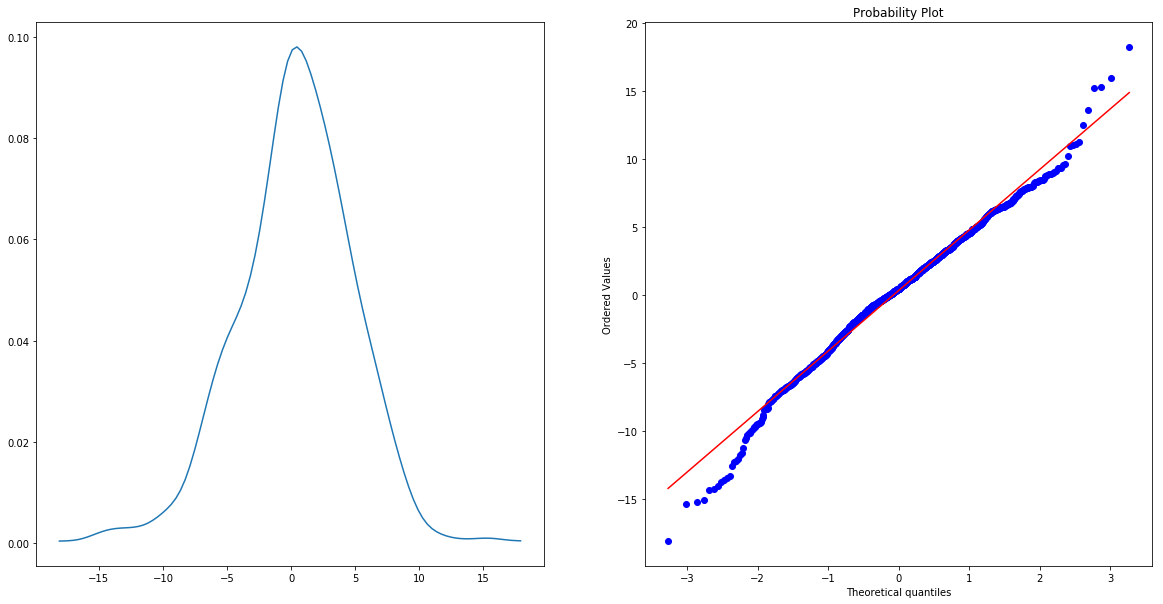

KstestResult(statistic=0.3439988759324879, pvalue=0.0)


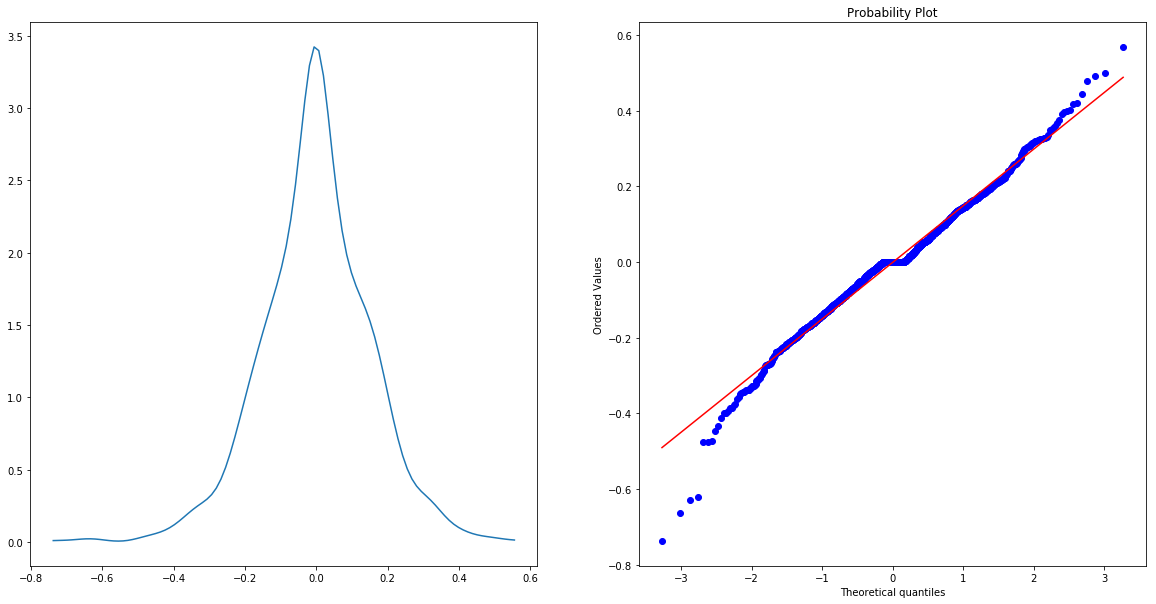

KstestResult(statistic=0.35806547685198353, pvalue=0.0)


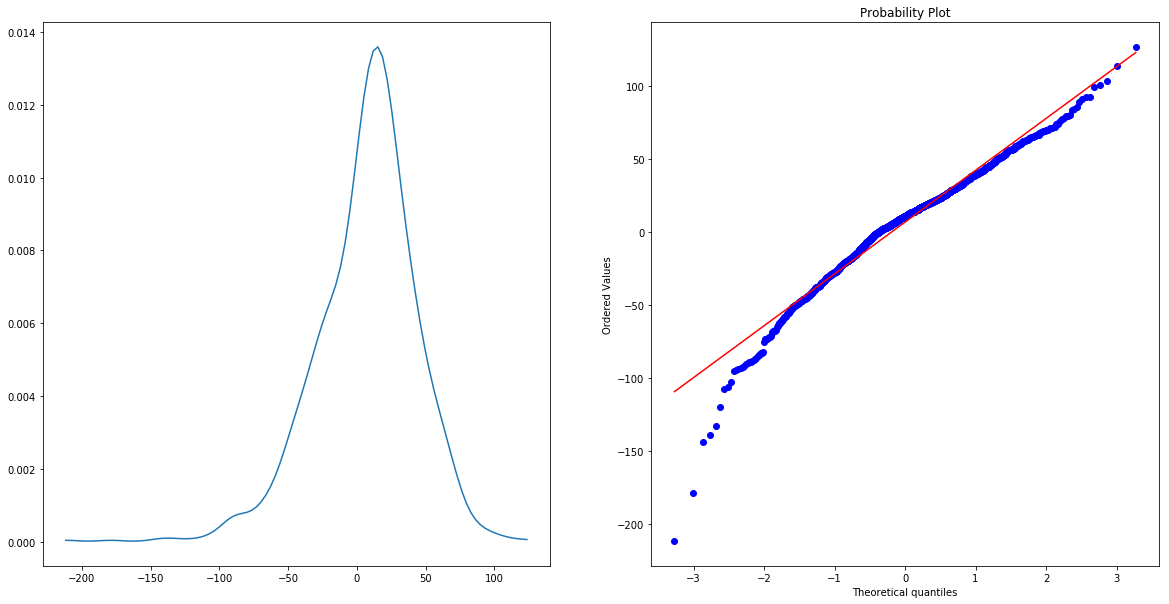

KstestResult(statistic=0.6148426480192616, pvalue=0.0)


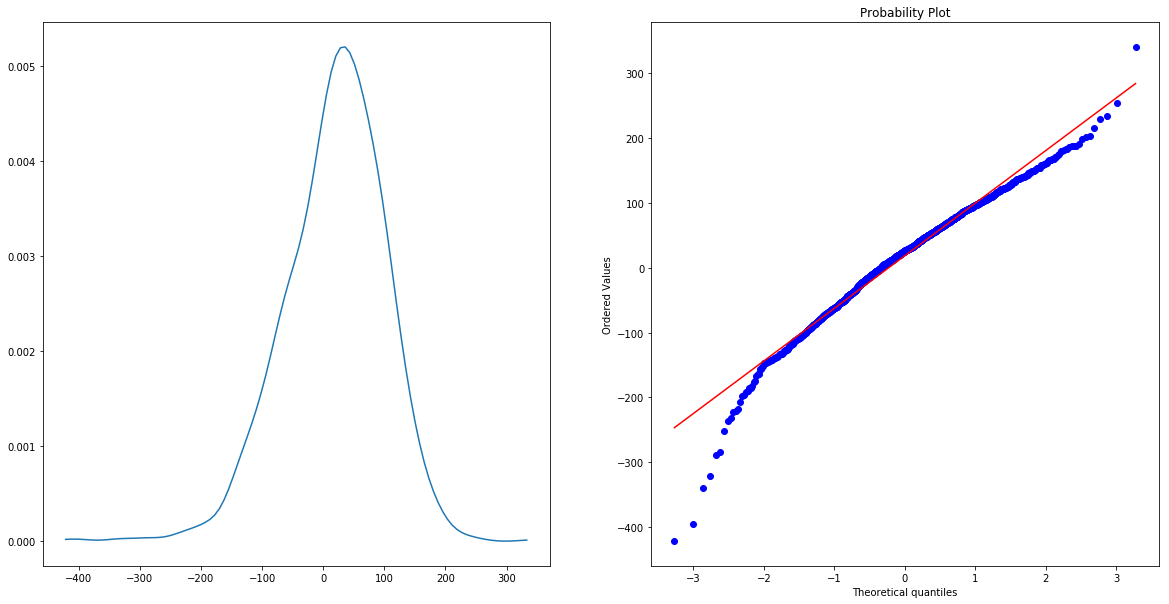

KstestResult(statistic=0.6229034954611364, pvalue=0.0)


In [32]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy

def plotDistribution(samples):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    f, ax = plt.subplots(1,2,figsize=(20,10))

    domain = np.arange(vmin, vmax, (vmax-vmin)/100)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    ax[0].plot(domain, density)
    stats.probplot(samples, dist="norm", plot=ax[1])
    plt.show()
    # Returning infos :
    print(stats.kstest(samples,'norm'))
    #print(stats.chisquare(samples))
    
for i in range(len(factorsReturns)):
    plotDistribution(factorsReturns[i])

<div class="alert alret-success">
    <p>We decided to show next to the main distrtibution plots the QQ-plots (quantile-quantile plots) for the different factors. Each QQ-plot compares the distrubution calculated from our dataset to the corresponding theoretical normal distribution. What we can see from these plots is that most of our points do fit well with a normal distribution but the differences with the most extreme quantiles can be significant, which shows how interesting it could be to find better (fitter) distributions to match our dataset.</p>
</div>

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

<div class="alert alert-success">
    <h2 id="more-distrib">More distributions</h2>
    <p>We would like to look at other distributions, to see if we can get a better fit which would allow us to get better results. As we discussed above, it seems that a distribution with a fatter tail would already represent a good improvement.</p>
    <p>
        To test different distributions, we decided to use <a href="https://docs.scipy.org/doc/scipy/reference/stats.html" target="_blank"><code>scipy.stats</code> distributions</a>, to be able to use the <code>kstest()</code> function (more information on this function below) provided by this module. Since we also wanted to use the distributions in later tests, we also needed the distributions to be implemented in <code>np.random</code>. This requirement took out several distribtuions from our initial list, among which <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dgamma.html#scipy.stats.dgamma" target="_blank">the <i>double gamma</i> distribution</a> which gave very good results with all four of our <i>factorsReturns</i> rows.
    </p>
    <p>
        The final distribution list is as follows:
        <table class="table">
            <tr>
                <td>chi2</td>
                <td>weibull_min</td>
                <td>gamma</td>
            </tr>
            <tr>
                <td>gumbel_r</td>
                <td>gumbel_l</td>
                <td>laplace</td>
            </tr>
            <tr>
                <td>logistic</td>
                <td>lognorm</td>
                <td>weibull_max</td>
            </tr>
            <tr>
                <td>pareto</td>
                <td>powerlaw</td>
                <td>t</td>
            </tr>
            <tr>
                <td>uniform</td>
                <td>vonmises</td>
            </tr>
        </table>
    </p>
    <h3>The Kolmogorov–Smirnov Test - <code>kstest()</code></h3>
    <p><small>From <a href="https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test" target="_blank">Wikipedia</a>.</small></p>
    <p>The KS Test is a <a href="https://en.wikipedia.org/wiki/Nonparametric_statistics" target="_blank">nonparametric test</a> used to compare a sample with a distribution. We will use it here to compare our datasets with the different distributions we want to use to represent it. The test scores will be used to rank the distributions.</p>
    <p>The test quantifies the distance between the sample and the distribution:</p>
    <img src="https://upload.wikimedia.org/wikipedia/commons/c/cf/KS_Example.png">
    <p>Since this test is based on the distance between our sample and the distribution, we want its value to be as close to 0 as possible.</p>
</div>

In [143]:
dist_names = [ 
    'chi2', 
    'gamma', 
    'gumbel_r', 
    'gumbel_l', 
    'laplace', 
    'logistic', 
    'lognorm', 
    'pareto', 
    'powerlaw', 
    't', 
    'uniform',  
    'weibull_min', 
    'weibull_max',
]

In [144]:
dico_names={}
for name in dist_names:
    dico_names[name]=[1]

<div class="alert alert-success">
    <p>We are now going to compute the <code>kstest()</code> value for all of our distributions, using the <code>scipy.optimize.fmin()</code> function to find the best possible parameter. Some distribution do require an argument, which will be optimzed, and some others do not (e.g. <code>norm</code>) but we can still optimize the first optional parameter.</p>
    <p>The <code>computeKstests()</code> function computes the <i>KStest</i> for all of our distributions. For each distribution, the script first optimizes the value of the parameter for the distribution to get the best possible <i>KStest</i> value, then computes that value and stores it (along with the parameter value).</p>
</div>

In [145]:
import scipy.optimize as so
def computeKstests(samples):
    res=[]
    for name in dico_names:
        bestParam = so.fmin(lambda x: stats.kstest(samples, name, [x])[0], 1, disp=False)
        dico_names[name]=bestParam
        res.append((name, stats.kstest(samples, name, bestParam), bestParam))
    return res # [(name, stats.kstest(samples, name, [1,1])) for name in dist_names]

dicoDistrib={}
for dist in dico_names:
    dicoDistrib[dist] = [0]*4
    
normResults=[0.3440, 0.3581, 0.6148, 0.6229]
for i in range(4):
    print("Kstest for factorReturns[{}]".format(i))
    res=computeKstests(factorsReturns[i])
    res.sort(key = lambda x: x[1])
    print("Distrib: %12s | Kstest: %6s | Param(s): %s" % ('multivarNorm', normResults[i], 'None'))
    for dist in res:
        dicoDistrib[dist[0]][i]=dist[2]
        if dist in res[:5]: print("Distrib: %12s | Kstest: %6s | Param(s): %s" % (dist[0], round(dist[1][0], 4), dist[2]))
    print()

Kstest for factorReturns[0]
Distrib: multivarNorm | Kstest:  0.344 | Param(s): None
Distrib:            t | Kstest: 0.1329 | Param(s): [0.38066406]
Distrib:     logistic | Kstest: 0.1954 | Param(s): [0.53896484]
Distrib:      laplace | Kstest:  0.243 | Param(s): [0.58925781]
Distrib:     gumbel_l | Kstest: 0.2653 | Param(s): [1.48984375]
Distrib:     gumbel_r | Kstest: 0.2692 | Param(s): [-0.32949219]

Kstest for factorReturns[1]
Distrib: multivarNorm | Kstest: 0.3581 | Param(s): None
Distrib:      laplace | Kstest:  0.346 | Param(s): [-0.00048828]
Distrib:            t | Kstest: 0.3581 | Param(s): [1.05553116e+14]
Distrib:     gumbel_l | Kstest: 0.3714 | Param(s): [0.37617187]
Distrib:     gumbel_r | Kstest: 0.3732 | Param(s): [-0.38417969]
Distrib:     logistic | Kstest: 0.4018 | Param(s): [-0.01054688]

Kstest for factorReturns[2]
Distrib: multivarNorm | Kstest: 0.6148 | Param(s): None
Distrib:            t | Kstest: 0.2481 | Param(s): [0.10888672]
Distrib:      lognorm | Kstest: 0.

<div class="alert alert-success">
    <p>We can see here that the only distribution that is present in all four top-5 lists is <a href="https://en.wikipedia.org/wiki/Student%27s_t-distribution" target="_blank">the Student's t-distribution</a>, which requires different parameters for the different samples we have.</p>
    <p>We stored the different <i>KStest</i> values for all of the samples and the distributions (with the optimized parameters) in <code>dicoDistrib</code>, and will use it in Question 10 to see how we can improve our results by changing the distribution. We will stick with the original normal distribution until then.</p>
</div>

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.

</div>

<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.

Correlation:


array([[1.        , 0.4009053 , 0.47917317, 0.4423977 ],
       [0.4009053 , 1.        , 0.58385221, 0.55593894],
       [0.47917317, 0.58385221, 1.        , 0.92053356],
       [0.4423977 , 0.55593894, 0.92053356, 1.        ]])

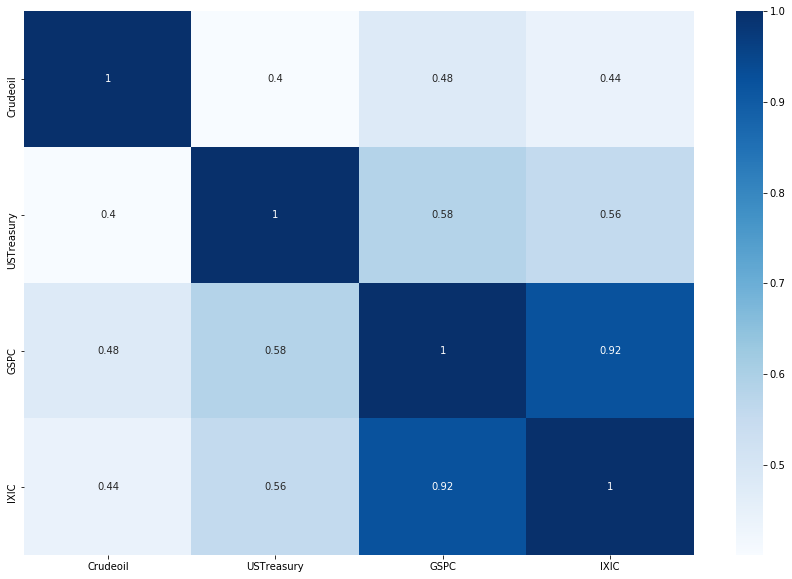

In [192]:
import seaborn as sns
correlation = np.corrcoef(factorsReturns)
factorNames = ["Crudeoil", "USTreasury", "GSPC", "IXIC"]
plt.figure(figsize=[15,10])
sns.heatmap(correlation, xticklabels=factorNames, yticklabels=factorNames, annot=True, cmap="Blues")
print("Correlation:")
display(correlation)

<div class="alert alert-success">
    <p>This correlation graph shows us how correlated a factor is to another, with 1 being absolute correlation (which explains <code>diag=[1,1,1,1]</code>), and 0 meaning absolute independance between factors.</p>
    <p>
        The main thing we can see here is that IXIC (Nasdaq) and GSPC (S&amp;P 500) have a very high correlation value (0.92), which makes sense since they are both stock indicators. Moreover, the correlation between USTreasury and GSPC/IXIC is above 50%, which makes sense given the possible its dependency the indicators. Finally, we can note that Crudeoil looks rather independent compared to the others, which we could expect for IXIC/GSPC, but which is a bit surprising for USTreasury (weakest correlation on our graph) since we could expect more dependency between the two.
    </p>
</div>

The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.


#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

</div>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

In [37]:
factorCov = np.cov(factorsReturns)
factorMeans = [sum(l)/len(l) for l in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)

### Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that helps us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it does give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [38]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    sorted(stats)
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Since your cluster has 12 cores (two Spark worker nodes, each with 6 cores), we can set `parallelism = 12` to dispatch simulation on these cores, across the two machines (remember, those are not really "physical machines", they are Docker containers running in our infrastructure).

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

In [39]:
# RUN SILMULATION
def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        
        # featurize the factors' returns
        trialFeatures = featurize(list(trialFactorReturns))
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = sum(np.array(weights).dot(trialFeatures))
        
        trialReturns.append(trialTotalReturn)
    return trialReturns

In [40]:
        
parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print ("Value at Risk(VaR) 5%:", float(valueAtRisk))
print ("Conditional Value at Risk(CVaR) 5%:", float(conditionalValueAtRisk))

Value at Risk(VaR) 5%: -19.810236246508474
Conditional Value at Risk(CVaR) 5%: -25.197807773880886


The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If `p-value` exceeds the critical value of the Chi-squared distribution, we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 50 exceptions over 500 time windows. Using the formula above, the test statistic `p-value` is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.

</div>

<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div> The loss is often having negative value, so, be careful when compare it to VaR.

In [41]:
from scipy import stats
import math

def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    # iterate over time intervals
    for i in range(0, len(stocksReturns[0])):
        # calculate the losses in each time interval
        loss = sum([item[i] for item in stocksReturns]) - valueAtRisk
        
        # if the loss exceeds VaR
        if loss<0:
            failures += 1
    return failures


#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

In [93]:
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = failures/total
    logNumer = (total - failures) * np.log(1-confidenceLevel) + failures * np.log(confidenceLevel)
    logDenom = (total - failures) * np.log(1-failureRatio) + failures * np.log(failureRatio)
    return -2 * (logNumer - logDenom)
 
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"


Now we can find the p-value accompanying our test statistic value.

In [94]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    N = len(stocksReturns)
    #print("num failures:", failures)
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    #return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0)

In [45]:
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

VaR confidence interval:  (-20.160098655564408, -19.646031316237483)
CVaR confidence interval:  (-25.694317803824067, -25.359157834187545)
Kupiec test p-value:  2.2708843847269447e-06


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

<div class="alert alert-success">
    <table class="table">
        <tr>
            <td><h4>Name</h4></td>
            <td><h4>Value</h4></td>
        </tr>
        <tr>
            <td>VaR</td>
            <td>$-19.41$</td>
        </tr>
        <tr>
            <td>VaR Conf. Interval</td>
            <td>$[-19.14,-19.37]$</td>
        </tr>
        <tr>
            <td>CVaR</td>
            <td>$-25.52$</td>
        </tr>
        <tr>
            <td>CVaR Conf. Interval</td>
            <td>$[-25.64,-25.59]$</td>
        </tr>
        <tr>
            <td>Nbr of Failures</td>
            <td>$110$</td>
        </tr>
        <tr>
            <td>Kupiec p-value</td>
            <td>$1.364 \times 10^{-7}$</td>
        </tr>
    </table>
    <p>By taking a quick look at our results, we can first see that our CVaR is a bit higher than our VaR, which we could expect since its conditional. Our VaR is quite low, which is a good: it means here that we will not lose more than around &dollar;20. Our confidence interval is quite tight which is a good thing as well. However, we can see that our VaR and CVaR are not in their respective confidence intervals, which is surprising. This could be due to imprecisions in the computations of the confidence intervals (not likely), or to approximations made when calculating `trials`. Either way, our VaR remains very close to the confidence interval (1&percnt;).</p>
    <p>Moreover, our <i>p-value</i> is quite low (compared to $0.05$, which is the ideal <i>p-value</i>), which means that our model is not accurate enough. This could be due to simplifications that we made, or our lack of factors when studying the stocks. It could also be linked to heuristics that we made earlier on. We will see afterwards how we can try to improve this value. But since it is too far from $0.05$, we can conclude that the <strong>null hypothesis</strong> cannot be applied here and that our model is still <i>not good enough</i> for our purpose.</p>
</div>

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>


In [95]:
num_stocks=100

print("\n[INFO] Getting rowStocks for an investment of {} stocks...".format(num_stocks))
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]
files = files[:num_stocks]
newRawStocks = [readYahooHistory(f) for f in files]
newRawStocks = list(filter(lambda instrument: ((instrument[-1][0].year-instrument[0][0].year)>=number_of_years)  , newRawStocks))
newStocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        newRawStocks))
newStocksReturns = list(map(twoWeekReturns, newStocks))
print("\n[INFO] Computing weights...")
newWeights = [estimateParams(stockReturns, factor_columns) for stockReturns in newStocksReturns]
print("Size of newWeights:", len(newWeights), len(newWeights[0]))
# factorCov and factorMeans do not change
print("\n[INFO] Computing MCS trials...")
parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bNewFactorWeights = sc.broadcast(newWeights)
newTrials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bNewFactorWeights.value
                ))
newTrials.cache()
print("\n[INFO] Computing (conditional) VaR...")
newValueAtRisk = fivePercentVaR(newTrials)
newConditionalValueAtRisk = fivePercentCVaR(newTrials)
print ("Value at Risk(VaR) 5%:", float(newValueAtRisk))
print ("Conditional Value at Risk(CVaR) 5%:", float(newConditionalValueAtRisk))
#print("\n[INFO] Computing (conditional) VaR confidence interval...")
#newVarConfidenceInterval = bootstrappedConfidenceInterval(newTrials, fivePercentVaR, 100, 0.05)
#newCvarConfidenceInterval = bootstrappedConfidenceInterval(newTrials, fivePercentCVaR, 100, .05)
#print("VaR confidence interval: " , newVarConfidenceInterval)
#print("CVaR confidence interval: " , newCvarConfidenceInterval)
print("\n[INFO] Computing Kupiec test p-value...")
print("Kupiec test p-value: " , kupiecTestPValue(newStocksReturns, newValueAtRisk, 0.05))
print("[INFO] Done.")


[INFO] Getting rowStocks for an investment of 100 stocks...

[INFO] Computing weights...
Size of newWeights: 78 13

[INFO] Computing MCS trials...

[INFO] Computing (conditional) VaR...
Value at Risk(VaR) 5%: -593.2434290022627
Conditional Value at Risk(CVaR) 5%: -1050.418209715794

[INFO] Computing Kupiec test p-value...
Kupiec test p-value:  6.14218675994604e-67
[INFO] Done.


<div class="alert alert-success">
    <h3>Results</h3>
    <p>The results presented down below may not be the ones displayed above, because we re-ran some cells after writing these comments.</p>
    <table class="table">
        <tr>
            <td><h4>Name</h4></td>
            <td><h4>Value for 35 stocks</h4></td>
            <td><h4>Value for 100 stocks</h4></td>
        </tr>
        <tr>
            <td>VaR</td>
            <td>$-19.41$</td>
            <td>$-596.04$</td>
        </tr>
        <tr>
            <td>VaR Conf. Interval</td>
            <td>$[-19.14,-19.37]$</td>
            <td>$[-556.24, -579.90]$</td>
        </tr>
        <tr>
            <td>CVaR</td>
            <td>$-25.52$</td>
            <td>$-1033.84$</td>
        </tr>
        <tr>
            <td>CVaR Conf. Interval</td>
            <td>$[-25.64,-25.59]$</td>
            <td>$[-1058.20, -1060.88]$</td>
        </tr>
        <tr>
            <td>Nbr of Failures</td>
            <td>$110$</td>
            <td>$237$</td>
        </tr>
        <tr>
            <td>Kupiec p-value</td>
            <td>$1.364 \times 10^{-7}$</td>
            <td>$0.0$</td>
        </tr>
    </table>
    <p>Our VaR and CVaR increased a lot (as well as the confidence intervals), which tells us that we might have much higher error rates. This is due to the size of our portfolio. We are trying to predict a relatively big portfolio, but the randomness involved in our model makes our predictions much further from the reality, as the size of the portfolio increases. The new <i>Kupiec p-value</i> is equal to 0 (or very small, for some runs - $10^{-60}$), which means that we can reject the <i>null hypothesis</i>. Our model does not represent our data accurately (what is happening here is a bit like <i>overfitting</i> in clustering problems in machine learning). </p>
</div>

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

<div class="alert alert-success">
    <p>As we saw <a href="#more-distrib">earlier</a>, we could use other distributions to represent our data. We found out a handful of them, stored in <code>dicoDistrib</code>, and we will try to use them here to compute the VaR, CVaR, confidence intervals and Kupiec p-value.</p>
</div>

In [146]:
dist_functions = { 
    'chi2':np.random.chisquare, 
    'gamma':np.random.gamma, 
    'gumbel_r':np.random.gumbel, 
    'gumbel_l':np.random.gumbel, 
    'laplace':np.random.laplace, 
    'logistic':np.random.logistic, 
    'lognorm':np.random.lognormal,  
    'pareto':np.random.pareto, 
    'powerlaw':np.random.power, 
    't':np.random.standard_t,  
    'uniform':np.random.uniform, 
    'weibull_min':np.random.weibull, 
    'weibull_max':np.random.weibull
}

In [147]:
import sys

def simulateTrialReturnsDiffDistrib(numTrials, f, args, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns=[f(arg) for arg in args]
        #trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        
        # featurize the factors' returns
        trialFeatures = featurize(list(trialFactorReturns))
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = sum(np.array(weights).dot(trialFeatures))
        
        trialReturns.append(trialTotalReturn)
    return trialReturns

parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)


for distrib in dicoDistrib:
    print()
    print("Distribution: %s" % distrib)
    try:
        tTrials = seedRDD.flatMap(lambda idx: \
                        simulateTrialReturnsDiffDistrib(
                            max(int(numTrials/parallelism), 1), 
                            dist_functions[distrib], dicoDistrib[distrib],
                            bFactorWeights.value
                        ))
        tTrials.cache()

        tValueAtRisk = fivePercentVaR(tTrials)
        tConditionalValueAtRisk = fivePercentCVaR(tTrials)
        print ("Value at Risk(VaR) 5%:", float(tValueAtRisk))
        print ("Conditional Value at Risk(CVaR) 5%:", float(tConditionalValueAtRisk))
        #tVarConfidenceInterval = bootstrappedConfidenceInterval(tTrials, fivePercentVaR, 100, 0.05)
        #tCvarConfidenceInterval = bootstrappedConfidenceInterval(tTrials, fivePercentCVaR, 100, .05)
        #print("VaR confidence interval: " , tVarConfidenceInterval)
        #print("CVaR confidence interval: " , tCvarConfidenceInterval)
        print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, tValueAtRisk, 0.05))
    except:
        print("Error:", sys.exc_info()[0])
print("[INFO] Done.")


Distribution: chi2
Value at Risk(VaR) 5%: 1.6560462202700164
Conditional Value at Risk(CVaR) 5%: 1.2395307378683125
Kupiec test p-value:  0.0

Distribution: gamma
Value at Risk(VaR) 5%: 1.9068787671251506
Conditional Value at Risk(CVaR) 5%: 1.6217538239078444
Kupiec test p-value:  0.0

Distribution: gumbel_r
Value at Risk(VaR) 5%: -30.064882344011792
Conditional Value at Risk(CVaR) 5%: -44.78487559400319
Kupiec test p-value:  0.00022940656097526868

Distribution: gumbel_l
Value at Risk(VaR) 5%: -1.8989067215642765
Conditional Value at Risk(CVaR) 5%: -9.939799027567172
Kupiec test p-value:  7.798720414054436e-265

Distribution: laplace
Value at Risk(VaR) 5%: -77.42388773767493
Conditional Value at Risk(CVaR) 5%: -195.34230500577996
Kupiec test p-value:  8.981306905843773e-27

Distribution: logistic
Value at Risk(VaR) 5%: -135.33753937266027
Conditional Value at Risk(CVaR) 5%: -261.20487284495056
Kupiec test p-value:  nan

Distribution: lognorm
Value at Risk(VaR) 5%: 54895.90138131287
C

<div class="alert alert-success">
    <p>So we tried different distribution to try to represent our data. But what we see from the results above is that we are way too far from what we would ideally want (a <i>VaR</i> around $20$, a <i>p-value</i> around $10^{-7}$), like what we got for the <code>multivariate_normal</code> distribution function. This is in part due to the lack of parameters used for the distributions. The multivariate normal one was generated from the covariance and the mean of factors where as the distributions we tested only come from one optimzed float. So we definetely lose information by not having as many parameters.</p>
    <p>If we take a look at the plots (with the normal distribution) in Step 2, we can see that a Gumbel distribution could work well to represent the data. And we can see this in our results above, with <code>gumbel_r</code> being the closest distribution to what we want.</p>
    <p>However, these tests and results are not satisfactory enough for us to choose any of these distributions over what we already had. So we will keep the <code>multivariate_normal</code> distribution throughout this notebook.</p>
    <p>Even though we were not able to find a better distribution, one further step could be to use several gaussians and mix them together to give us a distribution that will fit better our dataset.</p>
</div>

<div class="alert alert-success">
    <p>Everything below is our additional attemps in improving our results. To do so, we tried different approaches:</p>
    <ul>
        <li>Adding new factors to the four inital ones to see if we could improve our predictions.</li>
        <li>Using <strong>Brownian Geometric Motion</strong> in the <code>featurize()</code> function, to transform the factors matrix.</li>
        <li>Recommending the best stocks to invest in, according to chosen factors.</li>
    </ul>
</div>

# Adding factors

In order to improve our results, we are going to add some other factors, for which we downloaded the data from *Yahoo!*.

But we need to find which ones are the more revelant. To do so, let's look at the dataset:
For now, we have 4 factors: 'Crudeoil', 'USTreasury', 'GSPC', 'IXIC'
- **The return of crude oil**
- **The return of treasury bonds**
- **IXIC** *The Nasdaq Composite Index's*  
"As of May 31, 2016, the industry weights of the Nasdaq Composite Index's 2,569 individual securities are as follows: basis materials at 0.46%, consumer goods at 5.89%, consumer services at 20.92%. financials at 8.05%, health care at 13.94%, industrials at 6.35%, oil and gas at 0.64%, technology at 42.49%, telecommunications at 1.15%, and utilities at 0.11%."
[Source](https://www.investopedia.com/terms/n/nasdaqcompositeindex.asp#ixzz5CCCK6grG)
- **GSPC** *Standard & Poor's - S&P*
Standard & Poor’s, which has offices in 26 countries, is well-known to investors around the world for its wide variety of investable and benchmark indices, and the large number of credit ratings it issues. Standard & Poor’s is a market leader in its categories.
[source](https://www.investopedia.com/terms/s/sp.asp)

The two mains industies of those two Index are the consumer services and the thechnology. Thus we should add factors that influence directly thoses two industries, like 

- **DJI** Dow Jones Industrial Average
- **N225** Nikkei 225 (convert in USD)
- **RUT** Russell 2000
- **TNX** CBOE Interest Rate 10 Year T No
- **K** Kellogg Company
- **MU** Micron Technology
- **STM**STMicroelectronics N.V.

Those index are either related to the two mains industries (like the last thirds ones), or important index (like DJI,...).
We try to take pick different kind of Index to see which ones influence the more.


To study how adding some new factors affect our results, we are going to first get our data ready, then study what we get after cleaning up (correlation, VaR, ...). Finally, we will try to identify the best factors we can use for our stocks.

1. Cleaning our data
    * Get the factors
    * Select stocks
2. Correlation between the different factors
3. Distributions
4. VaR, CVaR, and their confidence intervals
5. Testing different combinations of factors

## 1 - Cleaning up our data

One thing we observed while taking a quick look at our new datasets is that some rows (i.e dates) had `null` as value. However, the functions we already coded do not take these possible null values into account, but would rather have an non-existing date to compute the estimated value for that date. So we need to take our all rows with `null` and our script will take care of adding the date and compute its values. To take out the `null` rows, we decided to directly do it with `bash`:

In [98]:
! sed -i '/null/d' ./monte-carlo-risk/factors/*.csv

Also, in the following cells, we use these variables, which should already have been defined:
```python
base_folder = "monte-carlo-risk/"
factors_folder= base_folder + "factors/"
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)
```

In [99]:
base_folder = "monte-carlo-risk/"
factors_folder= base_folder + "factors/"
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

### 1.1 - Get the factors

We store all of the factors we got from *investing.com* and *Yahoo!* in `all_factors`. 

In [100]:
from time import time

In [101]:
t0 = time()
all_factors_names = ['Crudeoil', 'USTreasury', 'GSPC', 'IXIC', 'DJI','N225', 'RUT','TNX', 'K','MU', 'STM']
all_factors_files_csv=[factorName + ".csv" for factorName in all_factors_names[2:]]
all_factors_files_csv = map(lambda fn: factors_folder + fn, all_factors_files_csv)
all_factors = factors1+[readYahooHistory(f) for f in all_factors_files_csv] # factors1 contains data from Crudeoil and USTreasury
print("[INFO] Getting all_factors took: %.3fs" % (time() - t0))

[INFO] Getting all_factors took: 1.160s


We can also compute `factorsReturns` now to speed up computations later on:

In [102]:
t0=time()
factors = list(map(lambda factor: \
                fillInHistory(
                    trimToRegion(factor, start, end), 
                start, end),
            all_factors))
    
factorsReturns = list(map(twoWeekReturns, factors))
print("[INFO] Computing factorsReturns took: %.4fs" % (time() - t0))

[INFO] Computing factorsReturns took: 0.0649s


### 1.2 - Select stocks

Below is a function that selects $n$ stocks ($n=35$ by default). So we will compute `stocksReturns` and use its value in the following computations.

In [103]:
def select_n_stocks(n=35):
    """
        stock_folder should have been already defined (='./monte-carlo-risk/stocks/')
    """
    # select path of all stock data files in "stock_folder"
    files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

    # assume that we invest only the first n stocks (for faster computation)
    files = files[:n]

    # read each line in each file, convert it into the format: (date, value)
    rawStocks = [process_stock_file(f) for f in files]

    # select only instruments which have more than 5 years of history
    # Note: the number of business days in a year is 260
    number_of_years = 5
    rawStocks = list(filter(lambda instrument: ((instrument[-1][0].year-instrument[0][0].year)>=number_of_years)  , rawStocks))

    stocks = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end), 
            rawStocks))
    return stocks

In [104]:
def select_stocks_returns(n=35):
    return list(map(twoWeekReturns, select_n_stocks(n)))

In [105]:
t0=time()
stocksReturns = select_stocks_returns()
print("[INFO] Computing stocksReturns took: %.3fs" % (time() - t0))

[INFO] Computing stocksReturns took: 1.430s


## 2 - Correlation between the different factors

Let us now display the correlation between all of our different factors. This can help us in choosing the right factors when computing the *VaR* and the *p-value*.

In [106]:
def display_correlation(factorsReturns):
    correlation = np.corrcoef(factorsReturns)
    plt.figure(figsize=[20,15])
    sns.heatmap(correlation, xticklabels=all_factors_names, yticklabels=all_factors_names, annot=True, cmap="GnBu")

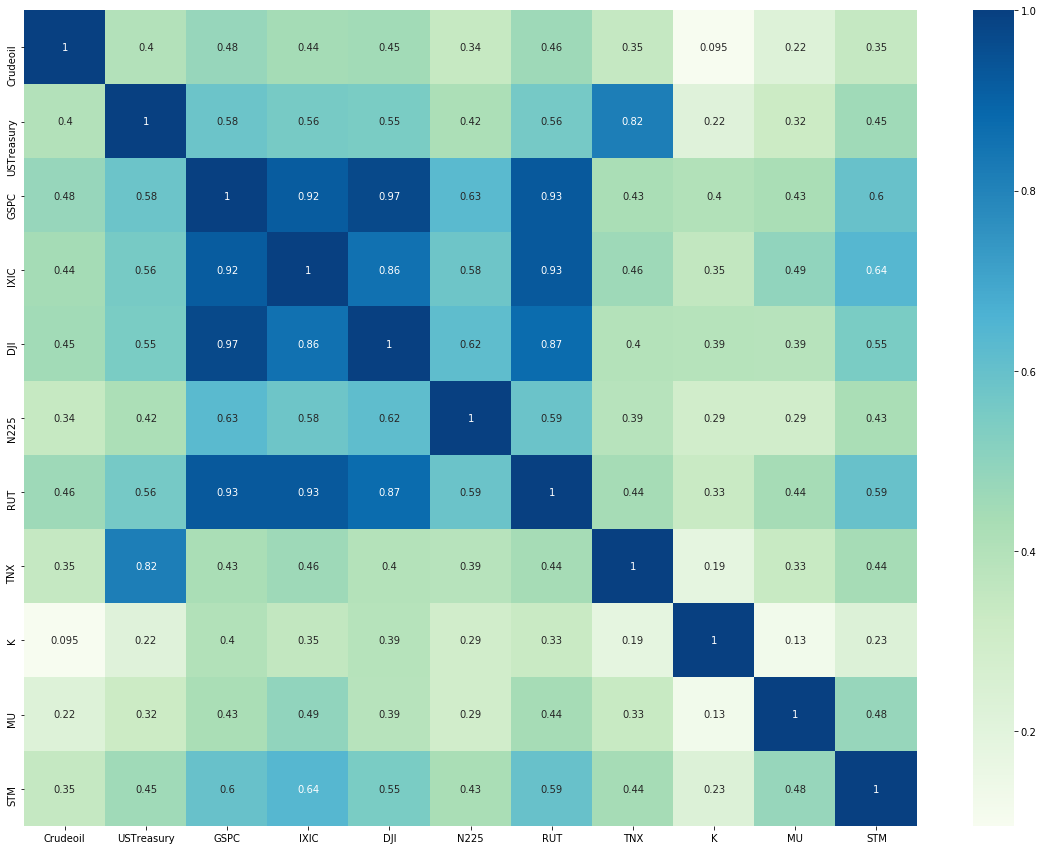

In [107]:
display_correlation(factorsReturns)

So we can see on the graph above that the most correlated factors are GSPC, IXIC, DJI, N225, RUT and STM. This makes sens because the first five are among the most important Index and thus directly impact the financial market. The last one, STMicroelectronics, is one of the biggest builder of semi-conductors circuit. Thus they are higlhy related to the technological industry.

However, some factors have a much weaker correlation with the others (Kellogs), which leads us to think that this factor might either add some new information or has no influence on the market.


## 3 - Distributions

In [108]:
def plotOneDistribution(samples, title):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    f, ax = plt.subplots(1,2,figsize=(10,4)) # make plot bigger
    domain = np.arange(vmin, vmax, (vmax-vmin)/100)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    ax[0].plot(domain, density)
    stats.probplot(samples, dist="norm", plot=ax[1])
    plt.title(title)
    plt.show()

In [109]:
def display_distributions(factorsReturns, factorNames):
    for i in range(len(factorsReturns)):
        print("Distribution associated to ",factorNames[i])
        plotOneDistribution(factorsReturns[i], "Distribution associated to {}".format(factorNames[i]))

Distribution associated to  Crudeoil


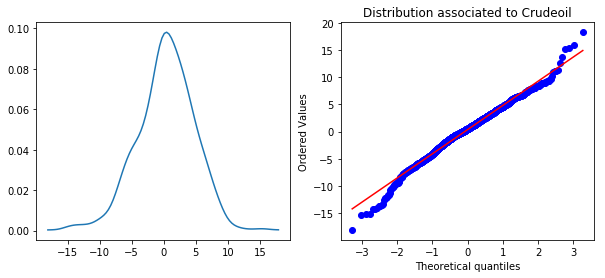

Distribution associated to  USTreasury


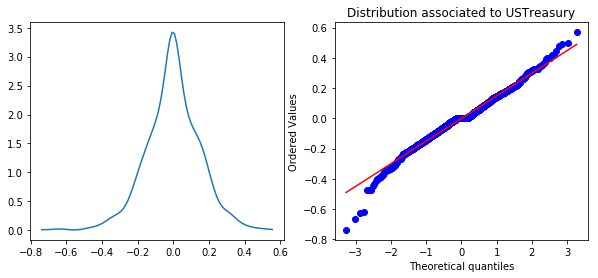

Distribution associated to  GSPC


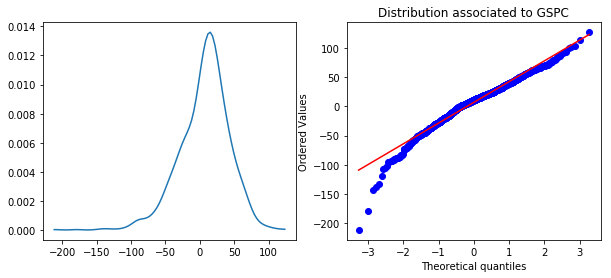

Distribution associated to  IXIC


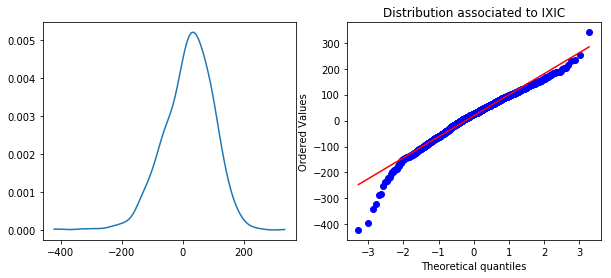

Distribution associated to  DJI


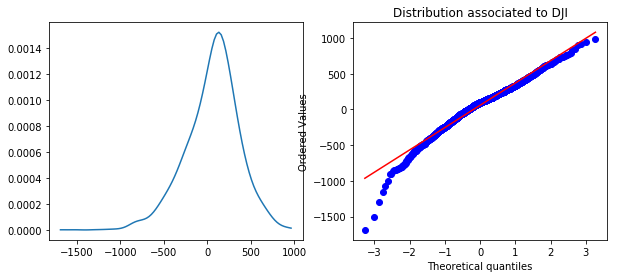

Distribution associated to  N225


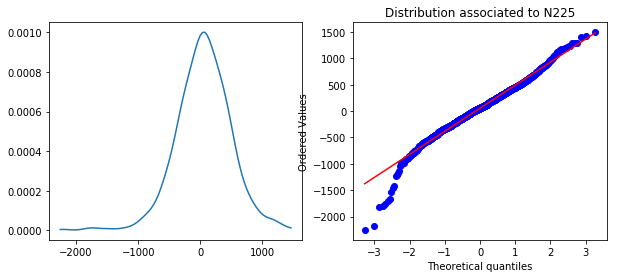

Distribution associated to  RUT


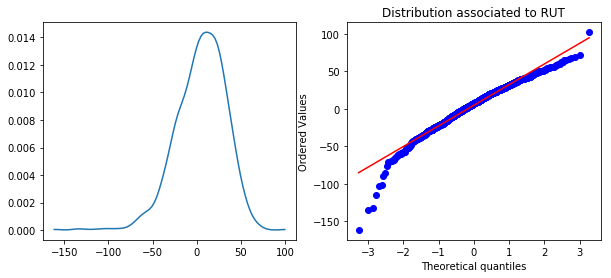

Distribution associated to  TNX


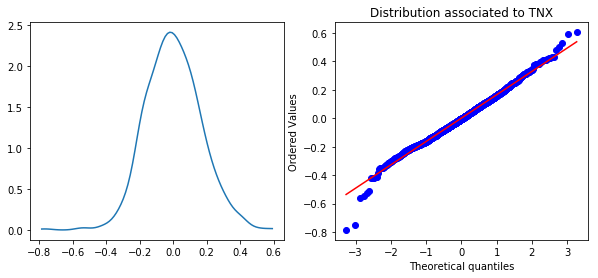

Distribution associated to  K


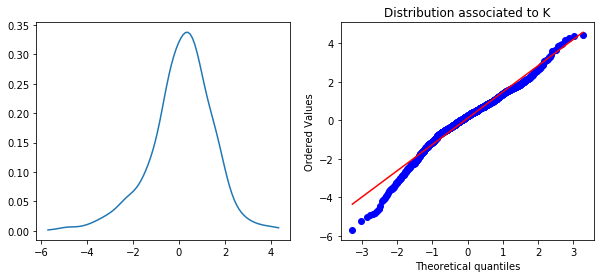

Distribution associated to  MU


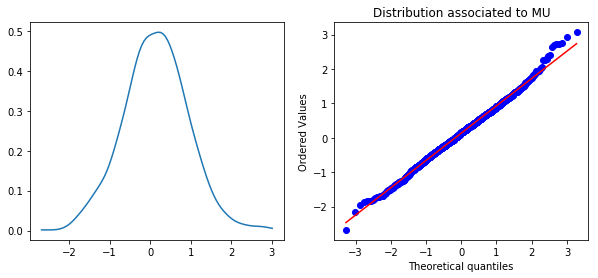

Distribution associated to  STM


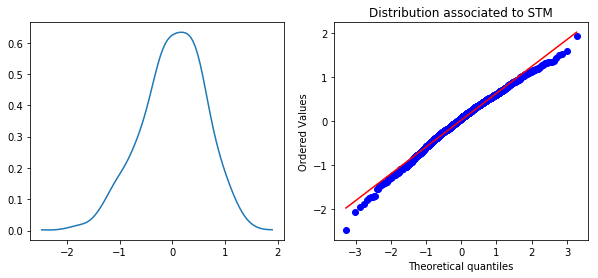

In [110]:
display_distributions(factorsReturns, all_factors_names)

## 4 - VaR, CVaR, and their confidence intervals

Now that we have all of our new factors ready, we can compute the *VaR* and compare it to what we had when only dealing with the first four factors. 

In [111]:
def display_vars(factorsReturns, stocksReturns, displayConfIntervals=False):
    factorMat = transpose(factorsReturns)
    factorFeatures = list(map(featurize,factorMat))
    factor_columns = np.array(factorFeatures)
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

    factorCov = np.cov(factorsReturns)
    factorMeans = [sum(l)/len(l) for l in factorsReturns]
    sample = np.random.multivariate_normal(factorMeans, factorCov)

    parallelism = 12
    numTrials = 10000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans, factorCov,
                        bFactorWeights.value
                    ))
    trials.cache()

    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)

    print ("Value at Risk(VaR) 5%:", float(valueAtRisk))
    print ("Conditional Value at Risk(CVaR) 5%:", float(conditionalValueAtRisk))

    if displayConfIntervals:
        varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
        cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
        print("VaR confidence interval: " , varConfidenceInterval)
        print("CVaR confidence interval: " , cvarConfidenceInterval)

In [112]:
t0=time()
display_vars(factorsReturns, stocksReturns, False)
print("[INFO] display_vars took %.3fs" % (time() - t0))

Value at Risk(VaR) 5%: -20.884435032380058
Conditional Value at Risk(CVaR) 5%: -27.571547225401364
VaR confidence interval:  (-20.914310402389027, -21.335923064998056)
CVaR confidence interval:  (-27.84762882384653, -27.549213008614768)
[INFO] display_vars took 131.882s


<table class="table">
    <tr>
        <td><h4>Name</h4></td>
        <td><h4>Using 4 first factors</h4></td>
        <td><h4>4 first factors + new factors</h4></td>
    </tr>
    <tr>
        <td>VaR</td>
        <td>$-19.41$</td>
        <td>$-20.83$</td>
    </tr>
    <tr>
        <td>VaR Conf. Interval</td>
        <td>$[-19.14,-19.37]$</td>
        <td>$[-21.09, -20.70]$</td>
    </tr>
    <tr>
        <td>CVaR</td>
        <td>$-25.52$</td>
        <td>$-27.41$</td>
    </tr>
    <tr>
        <td>CVaR Conf. Interval</td>
        <td>$[-25.64,-25.59]$</td>
        <td>$[-27.49, -27.67]$</td>
    </tr>
</table>

When computing the new *VaRs* and *CVaRs*, we cannot hope to get the exact same values since we are using a set of *factors markets* that is completely different from before. Morevoer, since there is some randomness involved in the computation, it does not look useful to compare *VaRs* and *CVaRs* for the same stocksReturns. What we want to make sure here is that the orders of magnitude are coherent with what we have seen since the beginning of this notebook.

Our values are indeed coherent with what we had before, so we can observe here the same low value for the VaR (and CVaR). The values are still low (which means low risk), and we can even see that we still have one value (the CVaR) which lies outside of its confidence interval (difference of less than 1%). Moreover, the tightness of the confidence intervals is still the same. Now that we checked for these values, we will use them to compare the *p-values* for different combinations of market factors.  

## 5 - Testing different combinations of factors

Now that we have a list of possible factors, we wish to find the best possible combination of these factors to optimize our results, i.e. get closer to a `p-value` of $0.05$.

To compute all of the possible combinations of factors, we decided to use `itertools.combinations()`. Then for each combination (a list of factors names), we compute the corresponding `p-value` and store in an array the tuples `(combination, p-value)`. These computations of the `p-values` are fairly quick, but the script still takes a lot of time to compute them since the number of possible combinations is equal to 2036 in our caseh:

$$\sum_{k=2}^{n=11} {n\choose{k}} = 2036$$

Once the computations are done, we can sort the array by `p-value` and see what are the best combinations. 

We expect the best combinations to take into account the most correlated factors, and to (maybe) discard the least correlated ones (such as *Crudeoil* for example).

In [113]:
import itertools

In [114]:
def return_p_value(allfactors, stocksReturns):
    '''
        The parameter allfactors should be a sub-list of all_factors. 
        The script takes care of getting factorsReturns.
    '''
    # compute factorsReturns
    factors = list(map(lambda factor: \
                fillInHistory(
                    trimToRegion(factor, start, end), 
                start, end),
            allfactors))

    factorsReturns = list(map(twoWeekReturns, factors))
    
    # compute weights
    factorMat = transpose(factorsReturns)
    factorFeatures = list(map(featurize,factorMat))
    factor_columns = np.array(factorFeatures)
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]
    
    # compute trials
    factorCov = np.cov(factorsReturns)
    factorMeans = [sum(l)/len(l) for l in factorsReturns]
    sample = np.random.multivariate_normal(factorMeans, factorCov)
    parallelism = 12
    numTrials = 10000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans, factorCov,
                        bFactorWeights.value
                    ))
    trials.cache()
    
    # compute VaR
    valueAtRisk = fivePercentVaR(trials)

    return kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)

We used the code below to compute the best combinations of factors, but commented it to be sure not to re-run it, as it takes around an hour to go through all 2036 combinations.
```python
p_values=[]
t0 = time()
for i in range(2,len(all_factors_names)):
    print("Combination length:", i)
    for n, names in enumerate(list(itertools.combinations(all_factors_names, i))):
        p_values.append((names, return_p_value([all_factors[all_factors_names.index(name)] for name in names], stocksReturns)))
print("took %.2fs" % (time() - t0))
p_values.sort(key= lambda x: x[1], reverse=True)
print("Combinations with the p-values closest to 5e-2:")
display(p_values[:10])
```

Here are the results for one of our runs:

| Combination | p-value |
| :---------: | ------: |
| ('GSPC', 'IXIC', 'RUT', 'TNX', 'K') | 0.0458 |
| ('Crudeoil', 'GSPC', 'IXIC', 'N225', 'RUT', 'TNX', 'K') | 0.0343 |
| ('USTreasury', 'DJI', 'N225', 'RUT', 'TNX', 'K', 'STM') | 0.0343 |
| ('GSPC', 'IXIC', 'DJI', 'N225', 'RUT', 'TNX', 'MU', 'STM') | 0.0343 |
| ('USTreasury', 'GSPC', 'N225', 'RUT') | 0.0255 |
| ('GSPC', 'DJI', 'RUT', 'TNX', 'STM') | 0.0255 |
| ('Crudeoil', 'GSPC', 'IXIC', 'RUT', 'TNX', 'K')| 0.0255 |
| ('Crudeoil', 'IXIC', 'N225', 'RUT', 'TNX', 'STM')| 0.0255 |
| ('GSPC', 'IXIC', 'N225', 'RUT', 'TNX', 'STM')| 0.0255 |
| ('Crudeoil', 'GSPC', 'IXIC', 'N225', 'RUT', 'K', 'MU')| 0.0255 |

The *p-value* for a given combination varies (as shown below) so the top-10 combinations presented above are probably not the absolute top-10, but their results are regular enough for us to use them as such.

In [115]:
for i in range(10):
    print(round(return_p_value([all_factors[all_factors_names.index(name)] for name in ('GSPC', 'IXIC', 'RUT', 'TNX', 'K')], stocksReturns), 5))

0.0069
0.0007
0.00336
0.0023
0.02548
0.00972
0.00972
0.00336
0.0069
0.0069


These are the *p-values* obtained for the combination `('GSPC', 'IXIC', 'RUT', 'TNX', 'K')`, with exactly the same parameters. Even though the *p-value* varies slightly, we can still see that the given combination is one of the best ones we have (even though it is not the best one as we first thought when computing over all of the possible combinations).

# Using Brownian Geometric Motion

When we were coding the `featurize()` function at the beginning of this notebook, we talked about the linerability of what we had and about a more choatic algorithm, which is the Brownian Geometric Motion.

To test this new `featurize()` function, we are going to use *factorsReturns* and *stocksReturns* that we computed in the previous section.

In [116]:
mu = 0.3
sigma = 0.65
T = 7
def featurizeBrownian(factorReturns):
    brownianmotion = [np.sign(x)*GBM_path(abs(x), mu, sigma, T, 2)[1] for x in factorReturns]
    brownianmotionbis = [np.sign(x)*GBM_path(abs(x), mu, sigma, T, 2)[1] for x in factorReturns]
    # concat new features
    return brownianmotion + brownianmotionbis + factorReturns

In [138]:
def brownian_p_value(factorsReturns, stocksReturns):
    # compute weights
    factorMat = transpose(factorsReturns)

    # here we replace featurize() with featurizeBrownian()
    factorFeatures = list(map(featurizeBrownian,factorMat))

    factor_columns = np.array(factorFeatures)
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

    # compute trials
    factorCov = np.cov(factorsReturns)
    factorMeans = [sum(l)/len(l) for l in factorsReturns]
    sample = np.random.multivariate_normal(factorMeans, factorCov)
    #Step 3&4: Generating samples, running simulation and calculating the VaR
    parallelism = 12
    numTrials = 10000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans, factorCov,
                        bFactorWeights.value
                    ))
    trials.cache()

    valueAtRisk = fivePercentVaR(trials)
    #conditionalValueAtRisk = fivePercentCVaR(trials)

    #print ("Value at Risk(VaR) 5%:", float(valueAtRisk))
    #print ("Conditional Value at Risk(CVaR) 5%:", float(conditionalValueAtRisk))

    # evaluating the results using backtesting method
    #varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    #cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
    #print("VaR confidence interval: " , varConfidenceInterval)
    #print("CVaR confidence interval: " , cvarConfidenceInterval)
    pValue = kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)
    #print("Kupiec test p-value: " , pValue)
    return valueAtRisk, pValue

Let us test these two functions. To do so, we are going to compute the *VaR* and the *p-value* several times for **the same** *factorsReturns* and *stocksReturns*:

In [139]:
def brown_two_scales(ax1, time, data1, data2):
    """https://matplotlib.org/2.1.2/gallery/api/two_scales.html"""
    ax2 = ax1.twinx()
    ax1.plot(time, data1, 'r-')
    ax1.set_xlabel('Nbr of simulations')
    ax1.set_ylabel('Value at Risk - VaR')
    ax2.plot(time, data2, 'b-')
    ax2.set_ylabel('p-value')
    return ax1, ax2

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


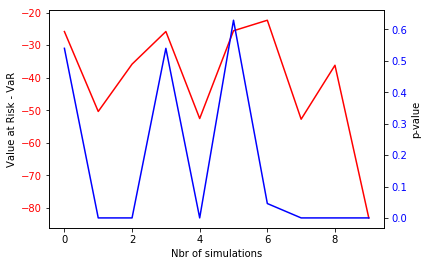

In [140]:
nbr_simul=10; V=[]; P=[]
for i in range(nbr_simul):
    print("{}%".format(int(round(100*i/nbr_simul))))
    v, p = brownian_p_value(factorsReturns, stocksReturns)
    V.append(v)
    if math.isnan(p):
        print(p)
        p=0
    P.append(p)

X = range(nbr_simul)
fig, ax = plt.subplots()
ax1, ax2 = brown_two_scales(ax, X, V, P)

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.show()

When using BGM, we can get good results (*p-value* close to $0.05$), as well as terrible ones (*p-value* close to $0$) or even errors (`nan`).

So overall, even though the initial `featurize()` function might not be ideal, it looks like choosing BGM over it would not improve our results and would bring in way more chaos that we want it to. Therefore we will stick with the original `featurize()` for the remainder of this notebook.

# Stocks Recommender

Now that we have the right set of *market factors*, we are going to try to predict which stocks to invest in. 
Indeed, if we decide to focus on some specfics factors, we can find the best stocks in wich we should invest according to the correlation of this stock to each factors. 

In [148]:
all_factors = factors1+factors2
# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: ((instrument[-1][0].year-instrument[0][0].year)>=number_of_years)  , rawStocks))

stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))

factors = list(map(lambda factor: \
            fillInHistory(
                trimToRegion(factor, start, end), 
            start, end),
        allfactors))

stocksReturns = list(map(twoWeekReturns, stocks))


factorsReturns = list(map(twoWeekReturns, factors))

# transpose factorsReturns
factorMat = transpose(factorsReturns)
# featurize each row of factorMat with the brownian geometric motion
factorFeatures = list(map(featurize,factorMat))
# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)
#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = np.array([estimateParams(stockReturn,factor_columns) for stockReturn in stocksReturns])


factorCov = np.cov(factorsReturns)
factorMeans = [sum(l)/len(l) for l in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)


In [36]:
def stocksrecommender(NumberofStocks):
    #find the best stocks according to the correlations 
    print("\n[INFO] Finding the {} Best Stocks...".format(NumberofStocks))
    bestCorrPerFactor = []
    #compile to correlation of the factors to each stocks
    for factorReturns in factorsReturns:
        bestCorrPerFactor += [sorted([(i,np.corrcoef(factorReturns,stockReturns)[0][1]) for i,stockReturns in enumerate(stocksReturns)], key=lambda x: -x[1])]
   
    # summming all the correlation for a same stock
    bestStocksDic={i:0 for i in range(len(stocksReturns))}
    
    for factor in bestCorrPerFactor:
        for corr in factor:
            bestStocksDic[corr[0]]+=corr[1]
    
    #Sorting the stocks by the sum of the correlation and pick the top NumberofStocks ones
    bestStocksCorr=sorted(list(bestStocksDic.items()),key=lambda x: -x[1])[:NumberofStocks]
    bestStocks=[x[0] for x in bestStocksCorr]
    bestStocksName=[files[i][24:-4] for i in bestStocks]
    print("The {} Best Stocks according to the correlation with the factors are: \n".format(NumberofStocks),bestStocksName)
    
    #Updating the stocksReturns and the weights depending on the best stocks we want
    stocksReturns_update=[stocksReturns[x] for x in bestStocks]
    weights_update=[weights[x] for x in bestStocks]

       
    #Generating samples, running simulation and calculating the VaR
    parallelism = 12
    numTrials = 10000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights_update)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans, factorCov,
                        bFactorWeights.value
                    ))
    trials.cache()

    print("\n[INFO] Computing (conditional) VaR...")
    ValueAtRisk = fivePercentVaR(trials)
    ConditionalValueAtRisk = fivePercentCVaR(trials)
    print ("Value at Risk(VaR) 5%:", float(ValueAtRisk))
    print ("Conditional Value at Risk(CVaR) 5%:", float(ConditionalValueAtRisk))
    print("\n[INFO] Computing (conditional) VaR confidence interval...")
    VarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    CvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
    print("VaR confidence interval: " , VarConfidenceInterval)
    print("CVaR confidence interval: " , CvarConfidenceInterval)
    print("\n[INFO] Computing Kupiec test p-value...")
    print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns_update, ValueAtRisk, 0.05))
    print("[INFO] Done.")
    

In [187]:
stocksrecommender(30)


[INFO] Finding the 30 Best Stocks...
The 30 Best Stocks according to the correlation with the factors are: 
 ['BMRN', 'ATTU', 'PLXS', 'BDE', 'CARB', 'XPLR', 'ABCB', 'RDVY', 'EZCH', 'IROQ', 'DRYS', 'HOLI', 'WVVI', 'HBCP', 'AQXP', 'KERX', 'ALDR', 'MEOH', 'WHFBL', 'CVGW', 'LAMR', 'MPAA', 'CGO', 'LMIA', 'RVNC', 'CSII', 'GENE', 'GNCMA', 'ADSK', 'AKER']

[INFO] Computing (conditional) VaR...
Value at Risk(VaR) 5%: -50.59041104240818
Conditional Value at Risk(CVaR) 5%: -65.04986266469093

[INFO] Computing (conditional) VaR confidence interval...
VaR confidence interval:  (-51.542280640965046, -50.429790086760896)
CVaR confidence interval:  (-65.42689183378958, -66.48106916133838)

[INFO] Computing Kupiec test p-value...
Kupiec test p-value:  0.07857490535464647
[INFO] Done.


In this part, we choose the the originals factors to test our recommender. The first thing we can notice is that the best stocks are highly related to the factors as planned. (part of the NASDAQ for exeample). Then the VaR doubled which suggested that those stocks are more risky but as the p-value is better and closer to 0.05  which means that our model is accurate enough and so the <strong>null hypothesis</strong> can be applied here.

# 6. Summary

In this notebook, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. 

Then, we had to study the **distribution of each market factor**. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor. We tried different distributions but the simple approach consisting in using normal distributions worked best. *Student's t-distribution* and the *double gamma distribution* gave us very good results as well but it was also very complicated to implement. Some distributions required more parameters and were therefore too complex to optimize. Some were just not implemented in `random` so we decided to discard those. To go further, we could try different approaches:
* Optimize several parameters to use more complicated distributions;
* Code an implementation of some distributions that are not on `random` (*double gamma* for example);
* Mix several gaussians to keep the code simple but get the final distribution complex enough to fit better our dataset;
* Use different distributions for all different factors.

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. We saw the influence of the number of stocks used in the simulation: by using **too many stocks**, we were getting **higher error rates** because the level of randomness involved in our model.

Throughout this notebook, we were only studying four market factors so we decided at the end to try to add some **more market factors** to base our predictions on more data. The results were overall better but we were also able to compute which combinations of factors gave us the best results. By doing so, we are able to choose the best market factors and improve our predictions. We tried this on random samples of our stocks but we could imagine choosing the best factors according to which stock(s) we want to study. We could have different best combinations for different stock baskets.

Moreover, we tried to improve the **featurize() function** used on the factors matrix. We used the Brownian Geometric Motion to add more chaos in what we thought was too linear. However, the results we got from BGM were not stable enough for us to use them.

Finally, we built a **recommendation script** that recommends the best $n$ stocks for a given set of market factors. This script uses the correlations between stocks and factors to choose the best stocks to invest in. We presented tests done with the four initial factors but one could try to use other factors to see how this changes the recommendations. One step further could be to use the best overall factors combinations (which we were to compute earlier) to recommend interesting stocks.

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).
- [A note on gamma difference distributions](https://pdfs.semanticscholar.org/0260/8b7e25aa49cfebc703991a5d6b59e8a114f7.pdf), by *Bernhard Klar*
- [Etude de la performance d'une Value-at-Risk choatique pour l'indice CAC40](http://www.lameta.univ-montp1.fr/Documents/DR2011-18.pdf), by *R Hennani* and *M. Terraza*
